### RLab06 - Martina Cacciola (2097476)

In [38]:
library(tidyverse)
library(ggplot2)
library(lubridate)
library(dplyr)
library(tidyr)
library(gridExtra)

# Exercise  1

In [39]:
Sys.setenv(PATH = "C:\\Program Files\\JAGS\\JAGS-4.1.0\\x64\\bin")

In [40]:
Sys.setenv(JAGS_HOME="C:\\Program Files\\JAGS\\JAGS-4.1.0")

In [41]:
install.packages("rjags", type = "binary")
install.packages("runjags", type = "binary")

Warning message:
"il pacchetto 'rjags' è in uso e non sarà installato"
Warning message:
"il pacchetto 'runjags' è in uso e non sarà installato"


In [42]:
library(rjags)
library(runjags)

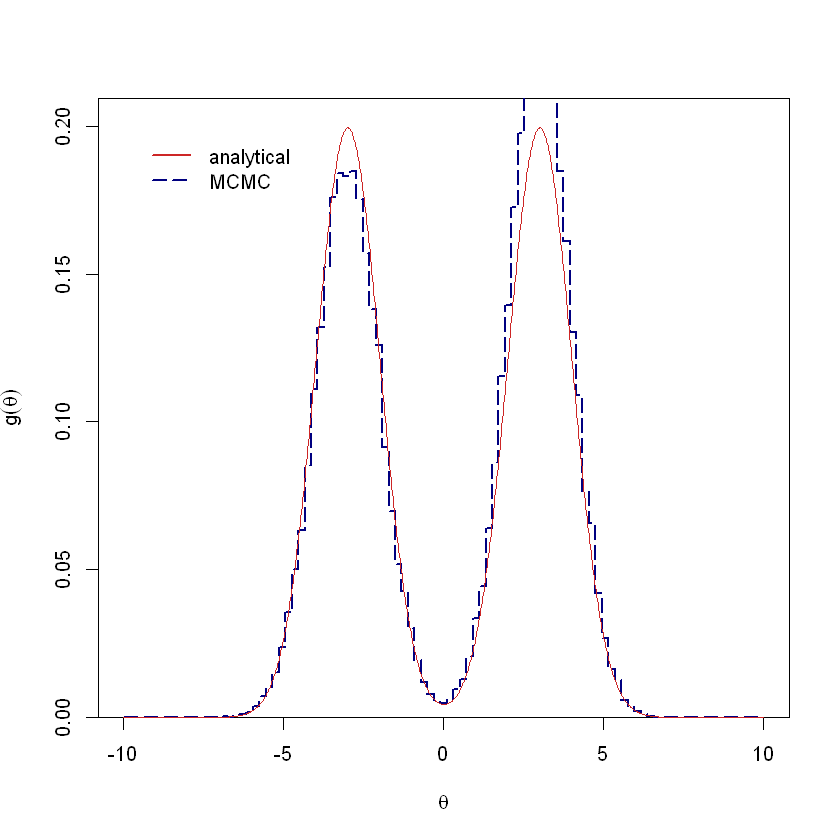

In [52]:
# Define the un-normalized posterior distribution
g <- function(theta) {
  return (0.5 * exp(-(theta + 3)^2 / 2) + 0.5 * exp(-(theta - 3)^2 / 2))
}

# Normalize the posterior distribution
normalize <- function(func, lower, upper, n = 1000) {
  integral <- integrate(func, lower, upper)$value
  x <- seq(lower, upper, length.out = n)
  y <- func(x) / integral
  return(list(x = x, y = y))
}
normalized_func <- normalize(g, -10, 10)

# Metropolis-Hastings algorithm
g.metropolis <- function(theta) {
  return(log(g(theta)))
}

metropolis_1dim <- function(func, theta.init, n.sample, sigma) {
  theta.cur <- theta.init
  func.Cur <- func(theta.cur)
  func.Samp <- matrix(data = NA, nrow = n.sample, ncol = 2 + 1)
  n.accept <- 0
  rate.accept <- 0.0
  
  for (n in 1:n.sample) {
    theta.prop <- rnorm(n = 1, mean = theta.cur, sd = sigma)
    func.Prop <- func(theta.prop)
    logMR <- func.Prop - func.Cur
    
    if (logMR >= 0 || logMR > log(runif(1))) {
      theta.cur <- theta.prop
      func.Cur <- func.Prop
      n.accept <- n.accept + 1
    }
    
    func.Samp[n, 1] <- func.Cur
    func.Samp[n, 2] <- theta.cur
  }
  
  return(func.Samp)
}

# Set the number of iterations and initial value
theta.init <- 0
sample.sig <- 1
n.sample <- 10^5
set.seed(20190513)

chain <- metropolis_1dim(func = g.metropolis,
                         theta.init = theta.init,
                         n.sample = n.sample,
                         sigma = sample.sig)

# Plotting
x <- seq(-10, 10, length.out = 10^4)
y <- g(x)
ymax <- 1.05 * max(y)

plot(x, y, type = "n", yaxs = "i", ylim = c(0, 1.05 * max(normalized_func$y)),
     xlab = expression(theta), ylab = expression(g(theta)))

sa <- which(chain[, 2] >= min(x) & chain[, 2] <= max(x))
hist <- hist(chain[sa, 2], breaks = seq(from = min(x), to = max(x), length.out = 100), plot = FALSE)
Zhist <- sum(hist$counts) * diff(range(hist$breaks)) / length(hist$counts)* max(y)
lines(hist$breaks, c(hist$counts * ymax / Zhist, 0),
      col = 'navy', type = "s", lwd = 2, lty = 5)

lines(normalized_func$x, normalized_func$y, col = 'firebrick3', lwd = 1, lty = 1)

leg.labels <- c('analytical', 'MCMC')
leg.colors <- c('firebrick3', 'navy')

legend("topleft", inset = 0.05, bty = 'n',
       legend = leg.labels, col = leg.colors,
       lwd = 2, lty = c(1, 5))

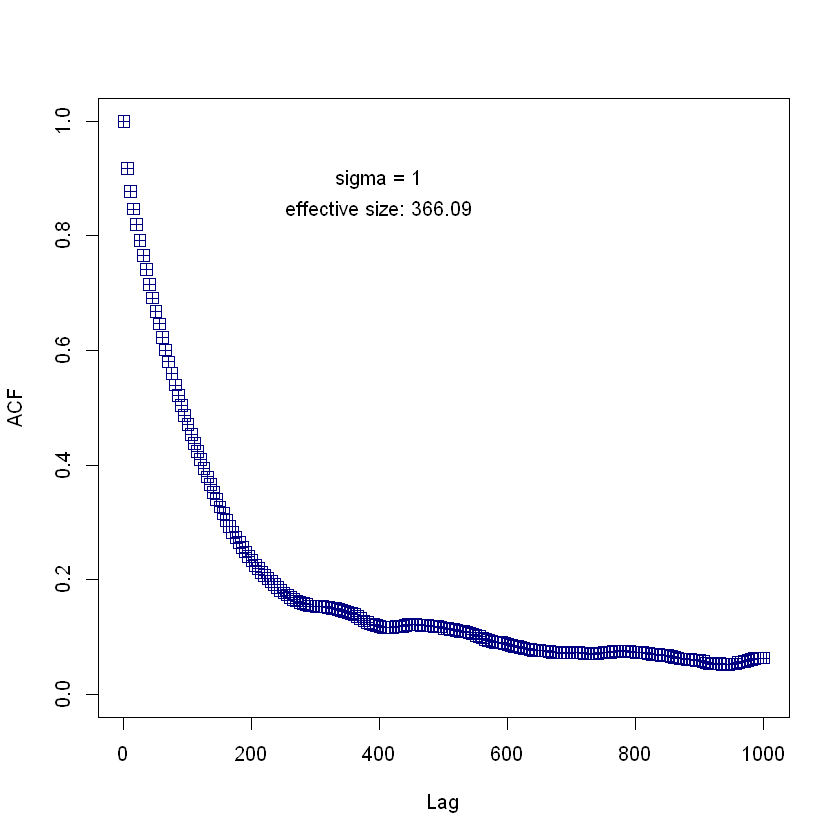

In [54]:
# Calculate autocorrelation of the chain
chain_mcmc <- as.mcmc(chain[,2])
my_lags <- seq(0, 1000, 5)
chain_acf <- autocorr(chain_mcmc, lags = my_lags)

# Plot the autocorrelation
plot(my_lags, chain_acf, ylim = c(0, 1),
     pch = 12, col = 'navy',
     xlab = 'Lag', ylab = 'ACF', cex = 1.3)
text(400, 0.9, paste('sigma = 1'))
text(400, 0.85, sprintf("effective size: %.2f", effectiveSize(chain_mcmc)))

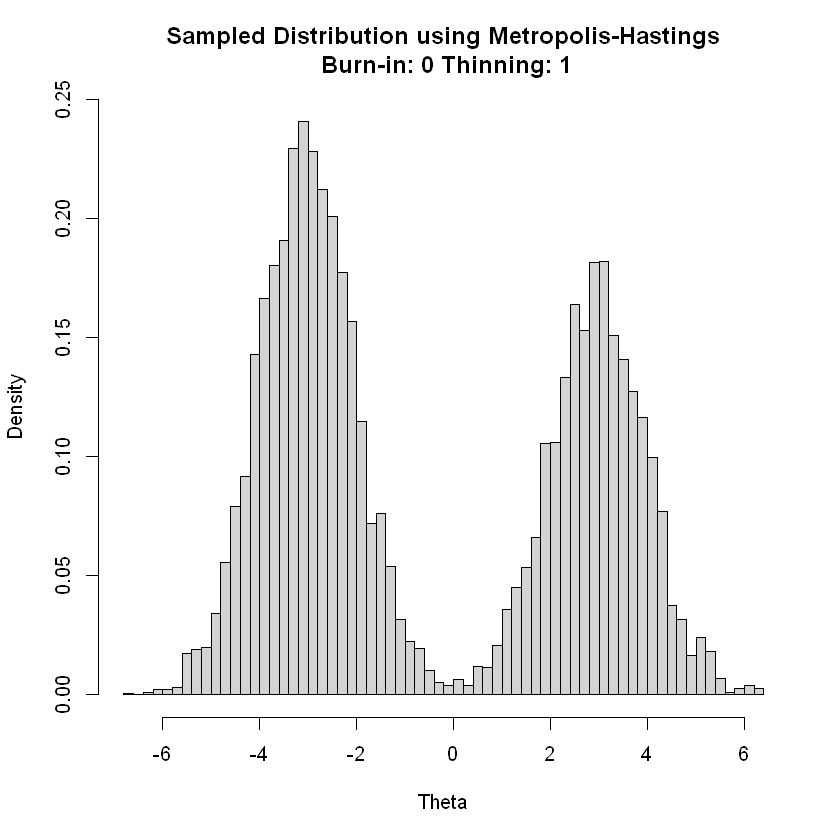

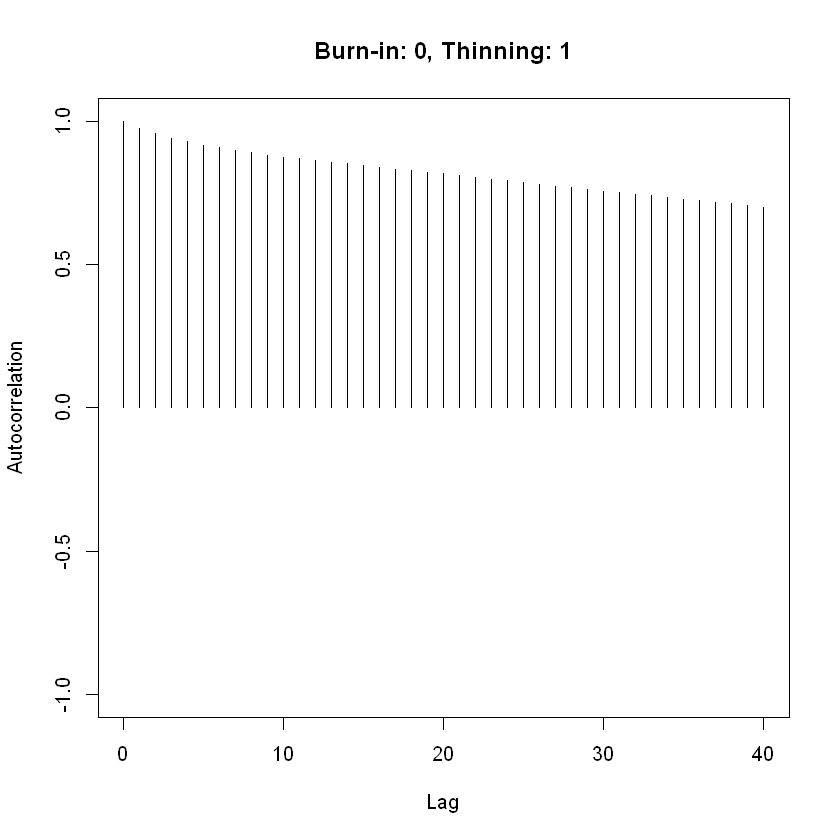

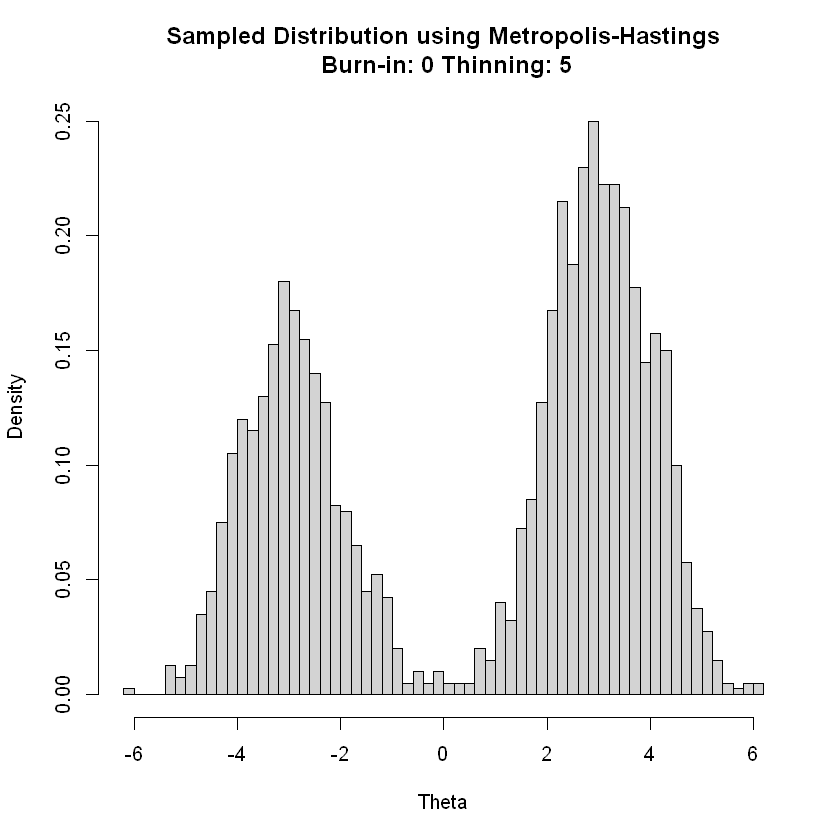

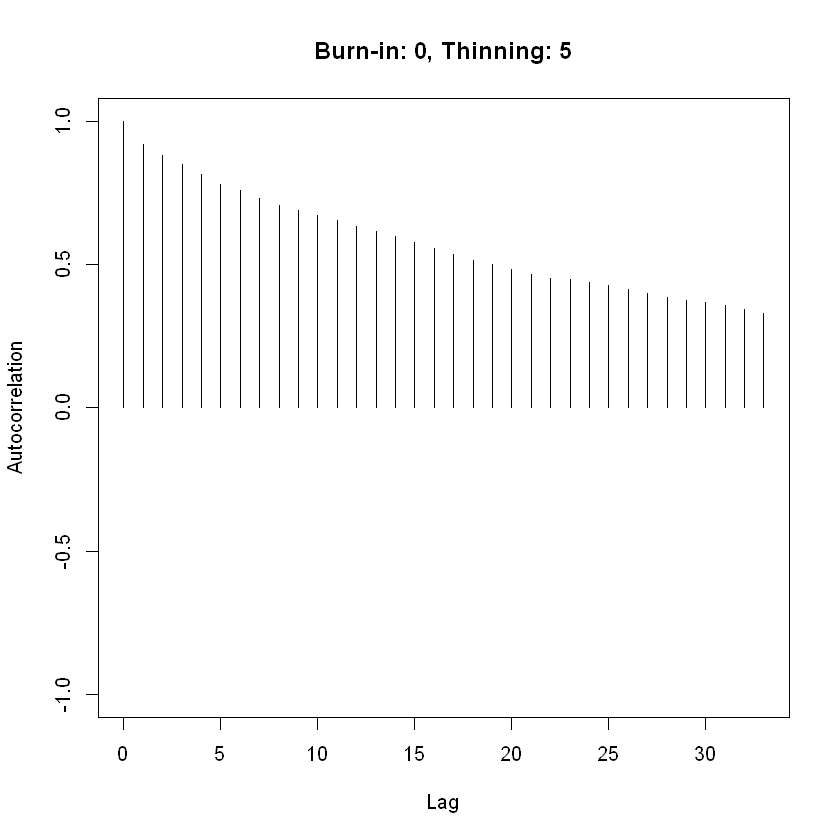

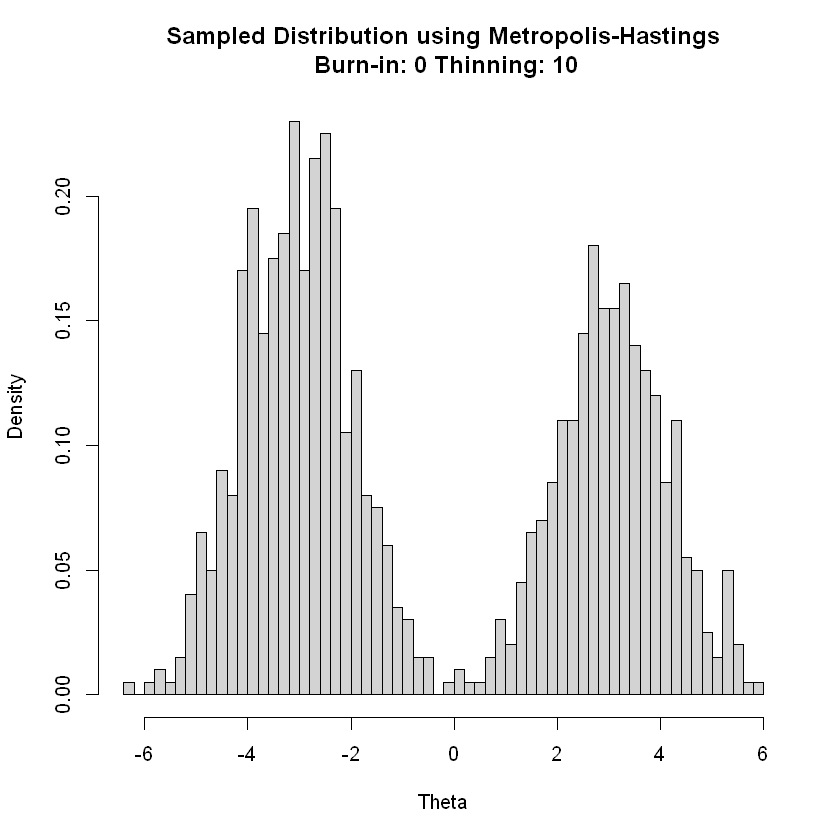

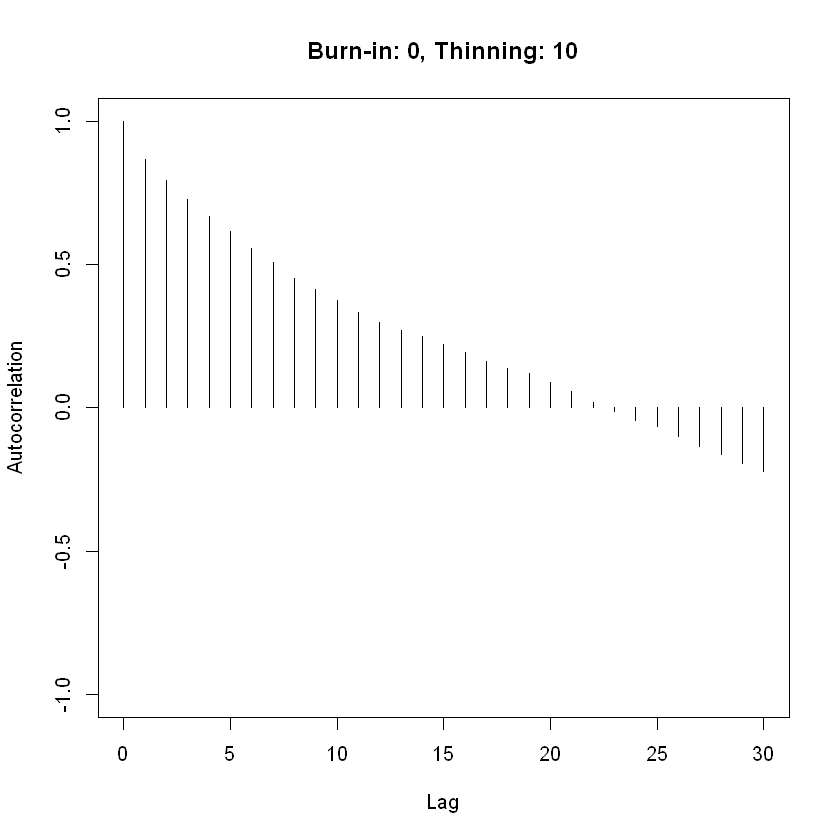

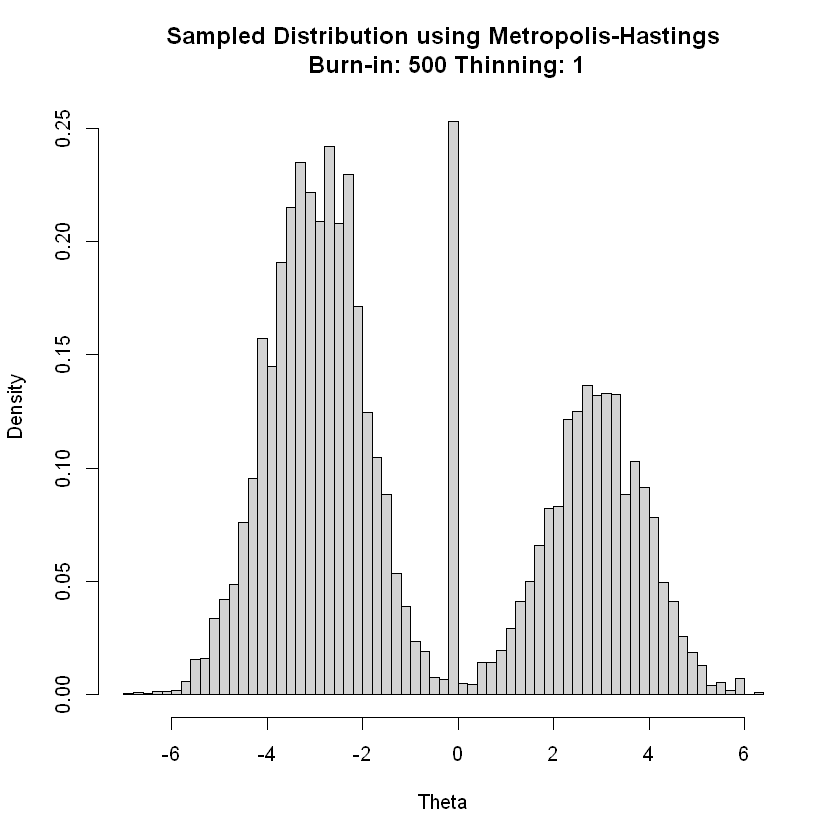

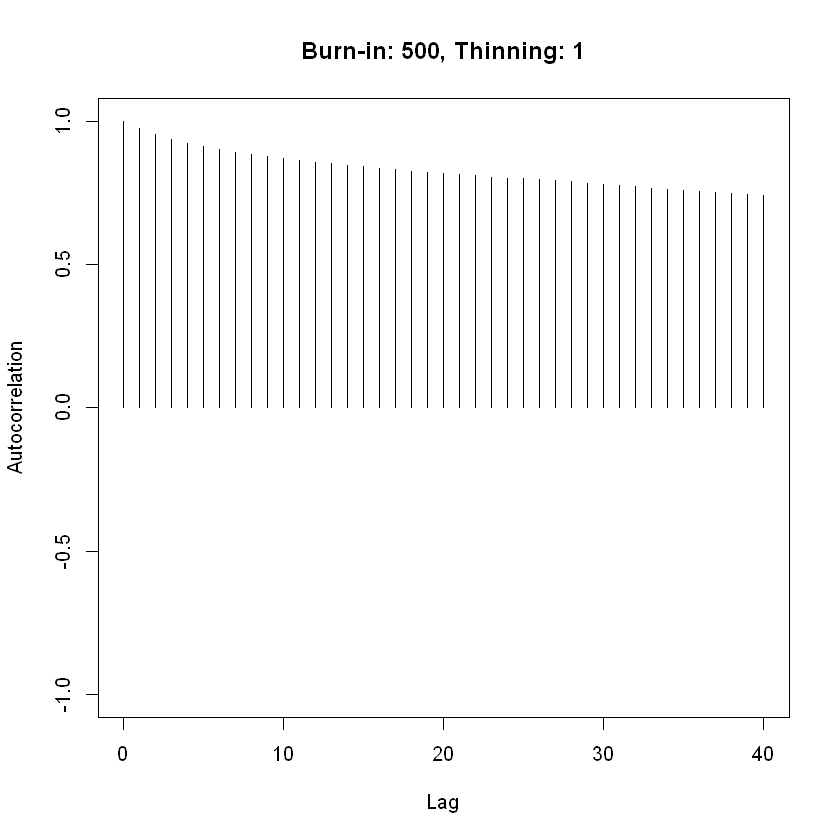

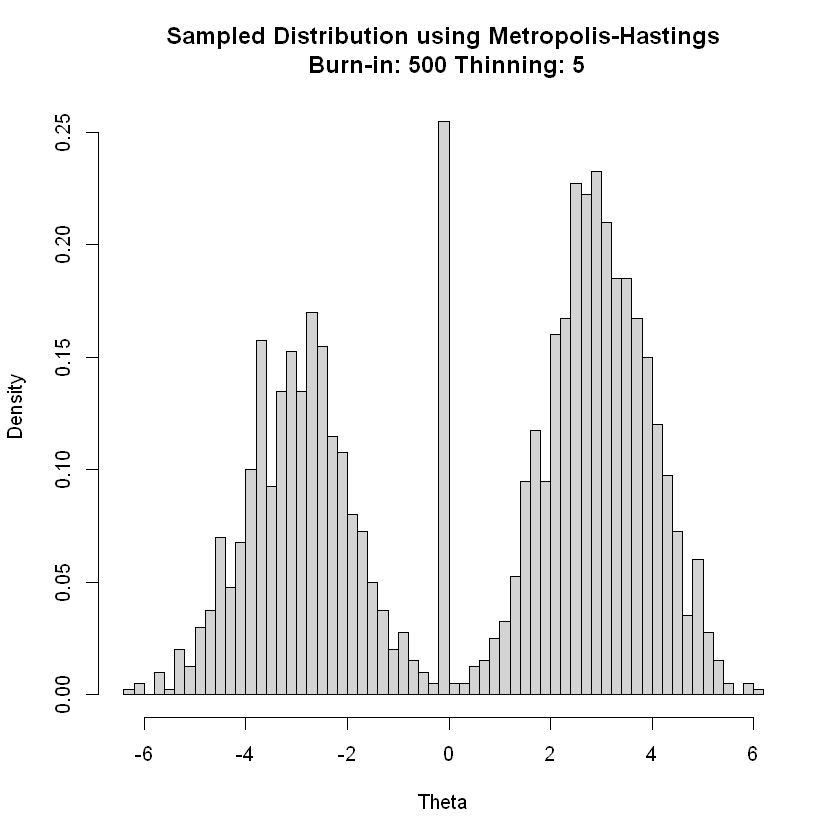

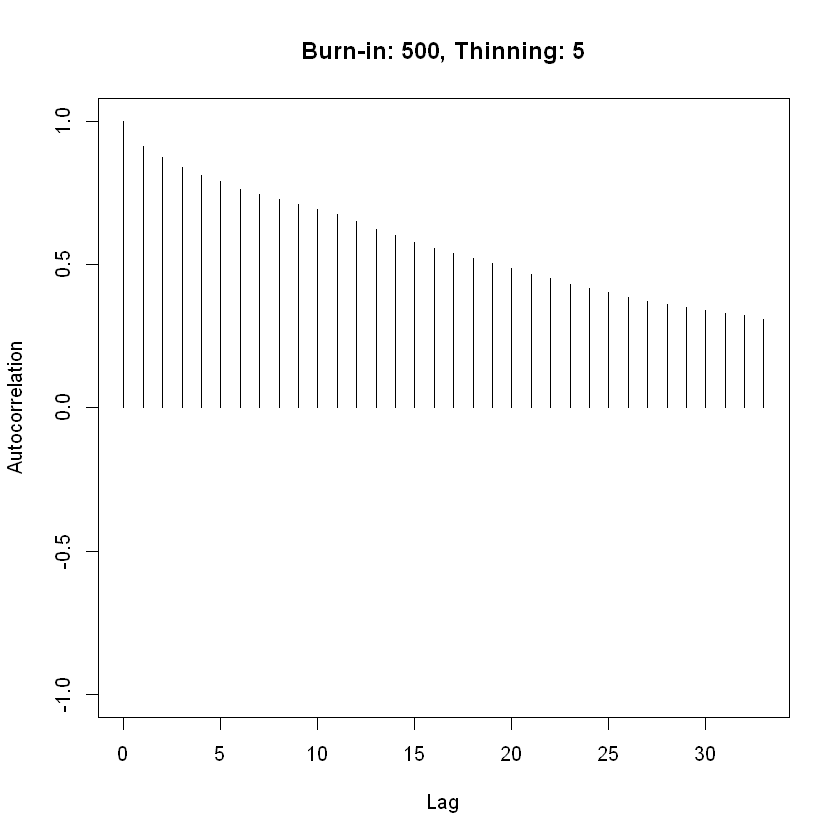

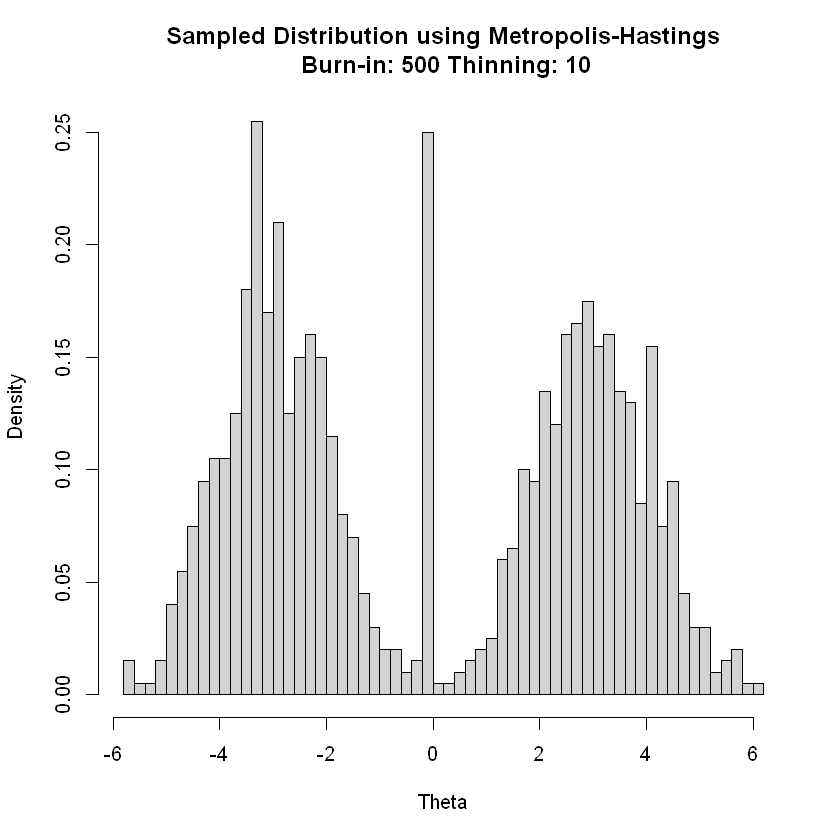

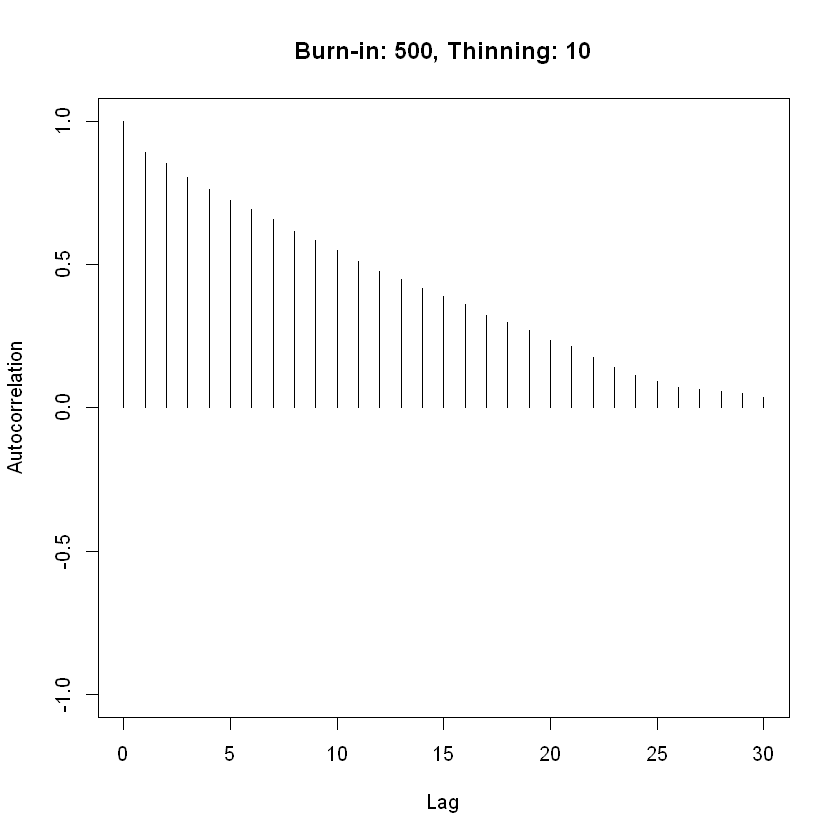

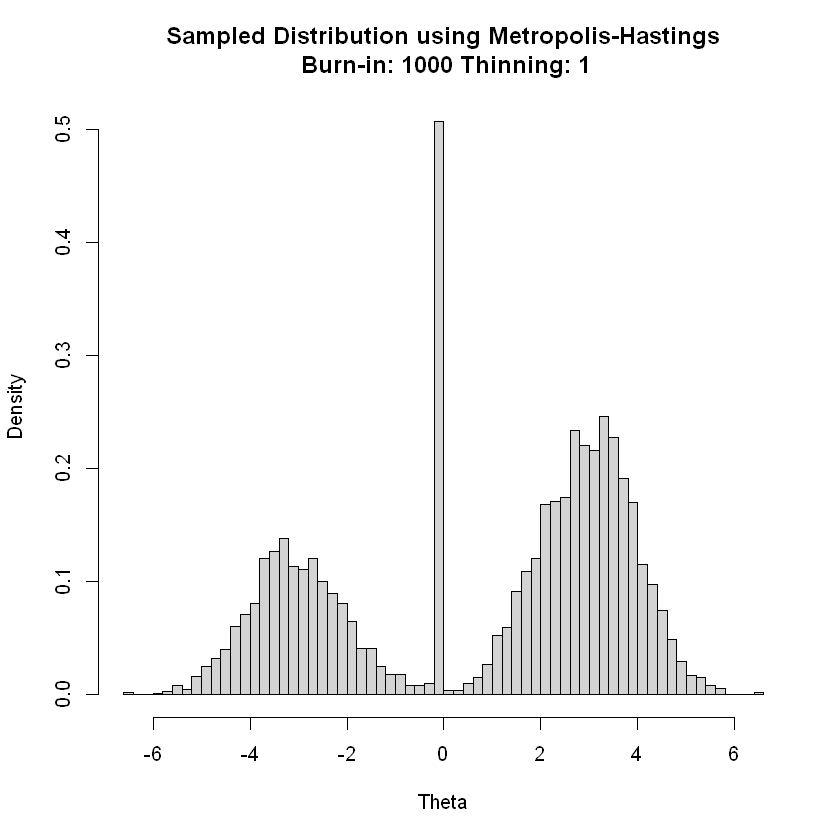

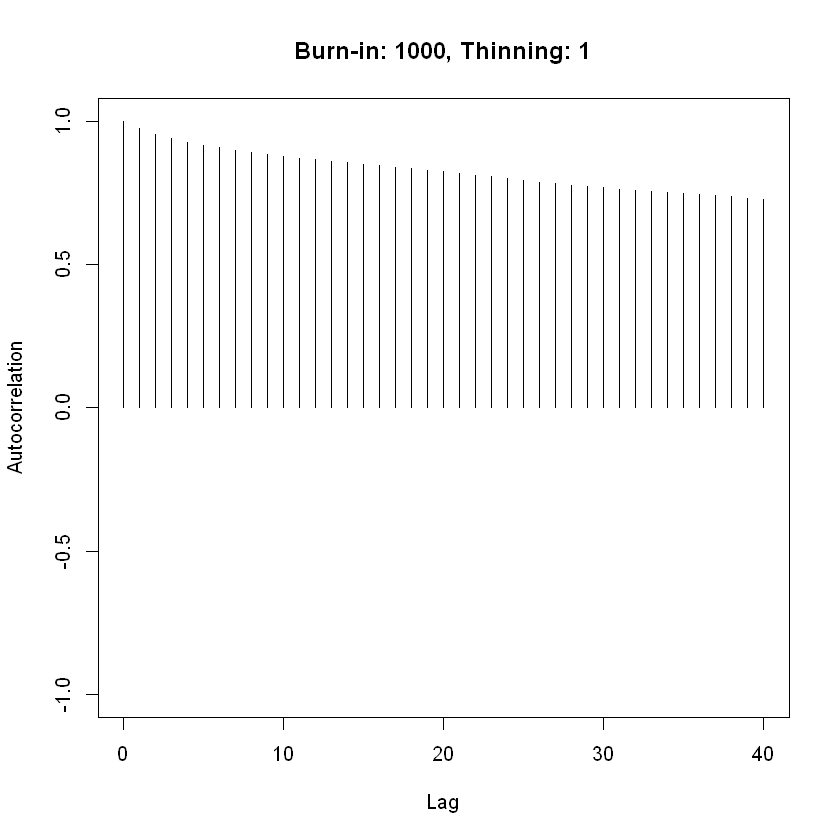

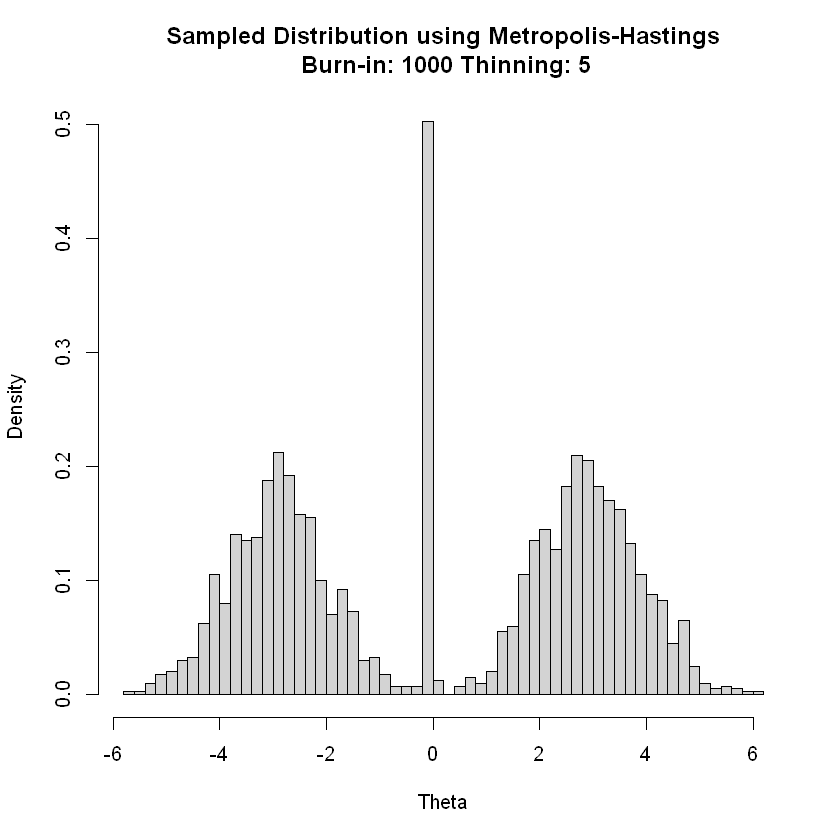

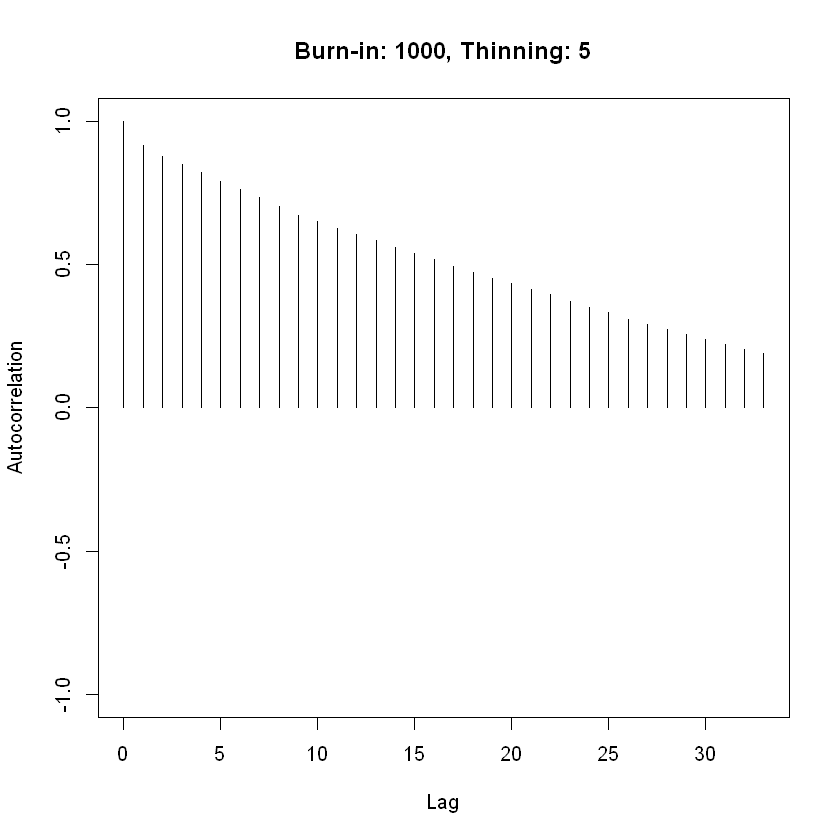

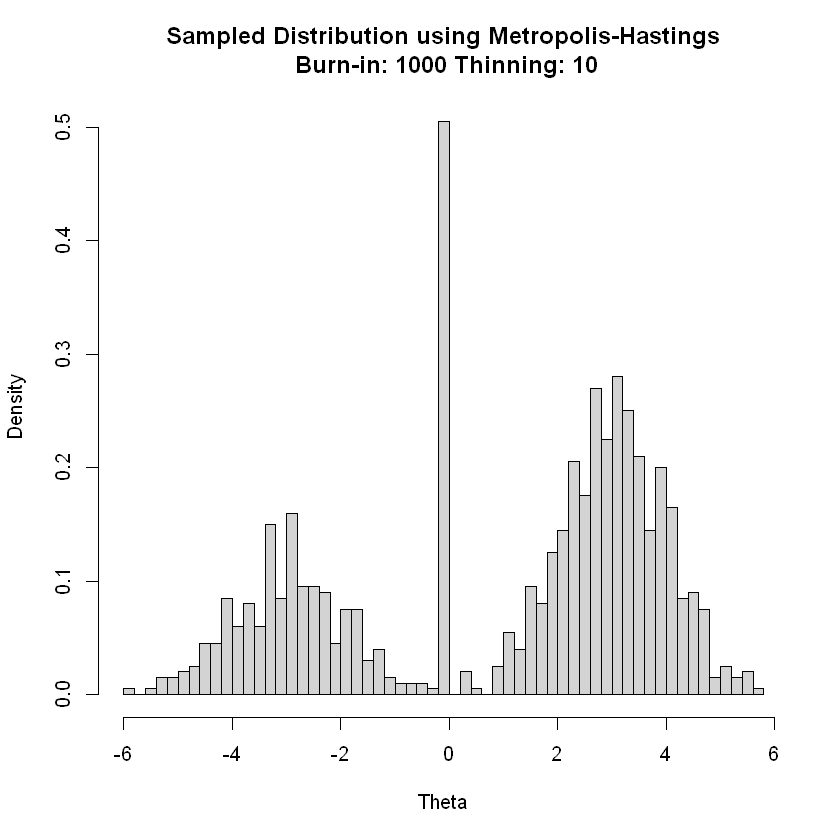

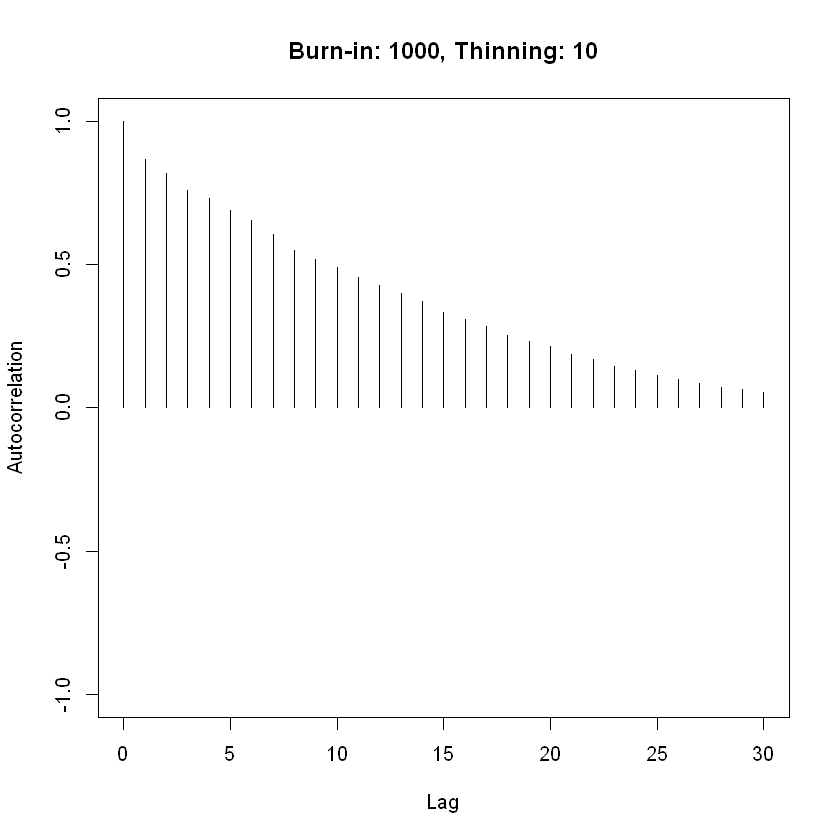

In [29]:
# Metropolis-Hastings algorithm with burn-in and thinning
metropolis_hastings <- function(num_iterations, initial_theta, burn_in, thinning) {
  num_samples <- num_iterations / thinning
  theta_chain <- numeric(num_samples)
  current_theta <- initial_theta
  
  for (i in 1:num_iterations) {
    # Generate candidate from proposal distribution (normal distribution)
    candidate_theta <- rnorm(1, current_theta, 1)
    
    # Calculate acceptance ratio
    acceptance_ratio <- min(1, g(candidate_theta) / g(current_theta))
    
    # Accept or reject candidate based on acceptance ratio
    if (runif(1) < acceptance_ratio) {
      current_theta <- candidate_theta
    }
    
    # Store the sample if burn-in period is over and thinning condition is met
    if (i > burn_in && (i - burn_in) %% thinning == 0) {
      theta_chain[(i - burn_in) / thinning] <- current_theta
    }
  }
  
  return (theta_chain)
}

# Set the number of iterations, initial value, and possible values for burn-in and thinning
num_iterations <- 10000
initial_theta <- 0
burn_in_values <- c(0, 500, 1000)
thinning_values <- c(1, 5, 10)

# Perform the loop between possible values
for (burn_in in burn_in_values) {
  for (thinning in thinning_values) {
    # Generate Markov Chain using Metropolis-Hastings algorithm with current burn-in and thinning
    chain <- metropolis_hastings(num_iterations, initial_theta, burn_in, thinning)
    
    # Analyze the chain
    chain_coda <- mcmc(chain)

    # Plot the sampled distribution
    hist(chain, breaks = 50, freq = FALSE,
         main = paste("Sampled Distribution using Metropolis-Hastings\n",
                      "Burn-in:", burn_in, "Thinning:", thinning),
         xlab = "Theta", ylab = "Density")
    
    # Plot the chain autocorrelation
    autocorr.plot(chain_coda, main = paste0("Burn-in: ", burn_in, ", Thinning: ", thinning))
  }
}


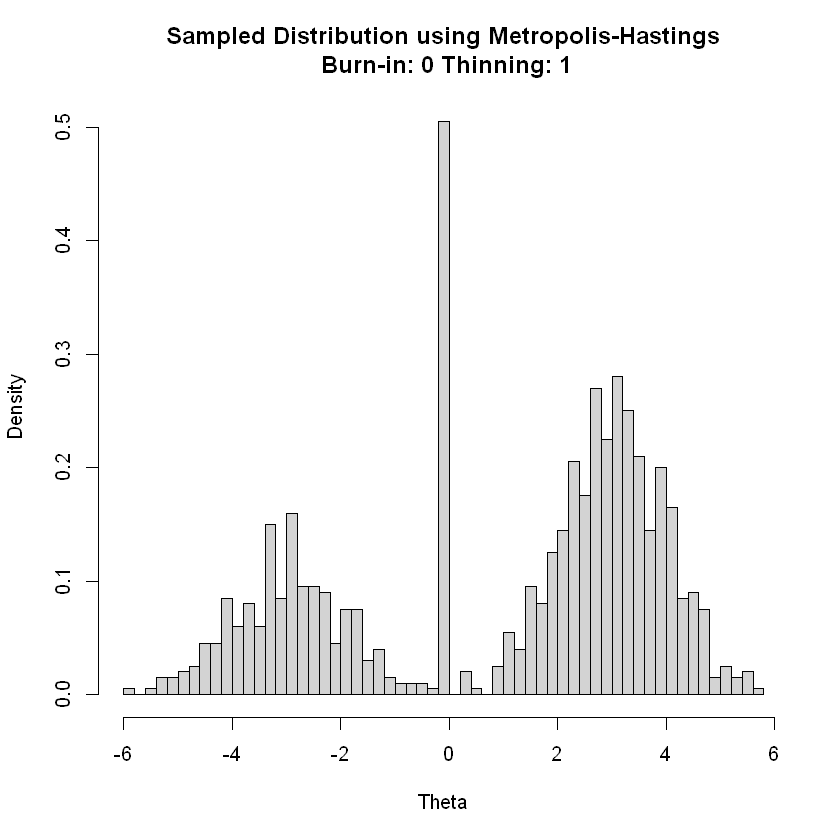

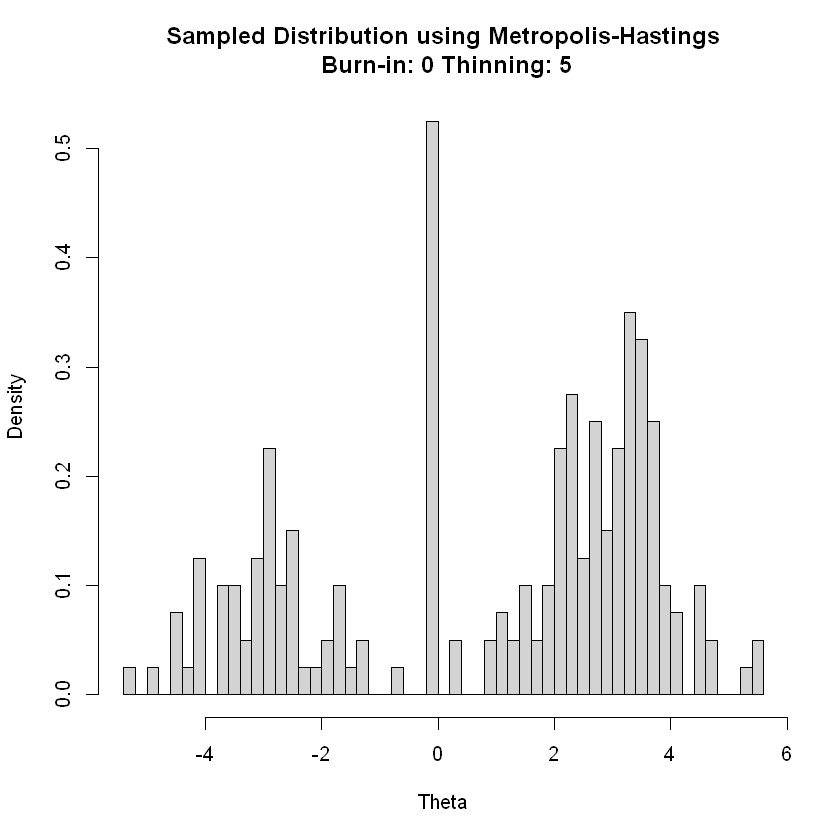

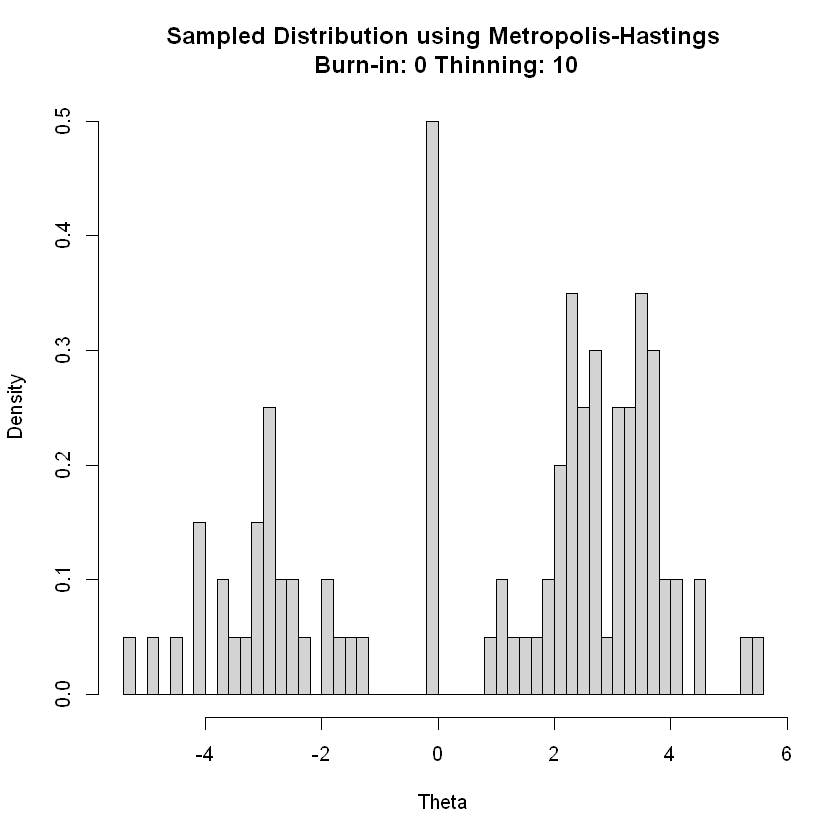

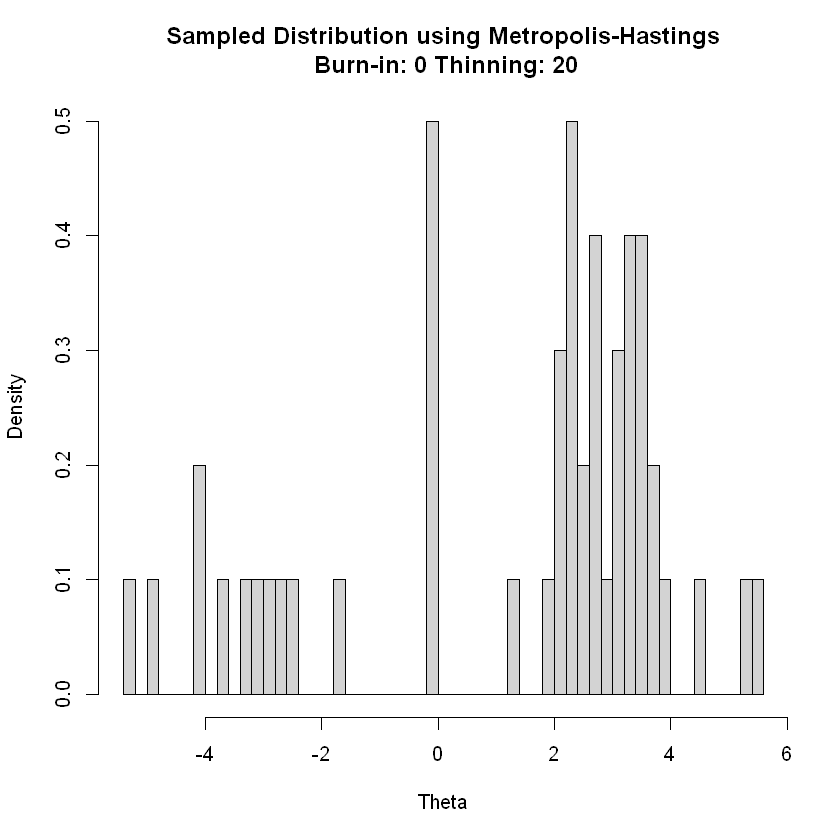

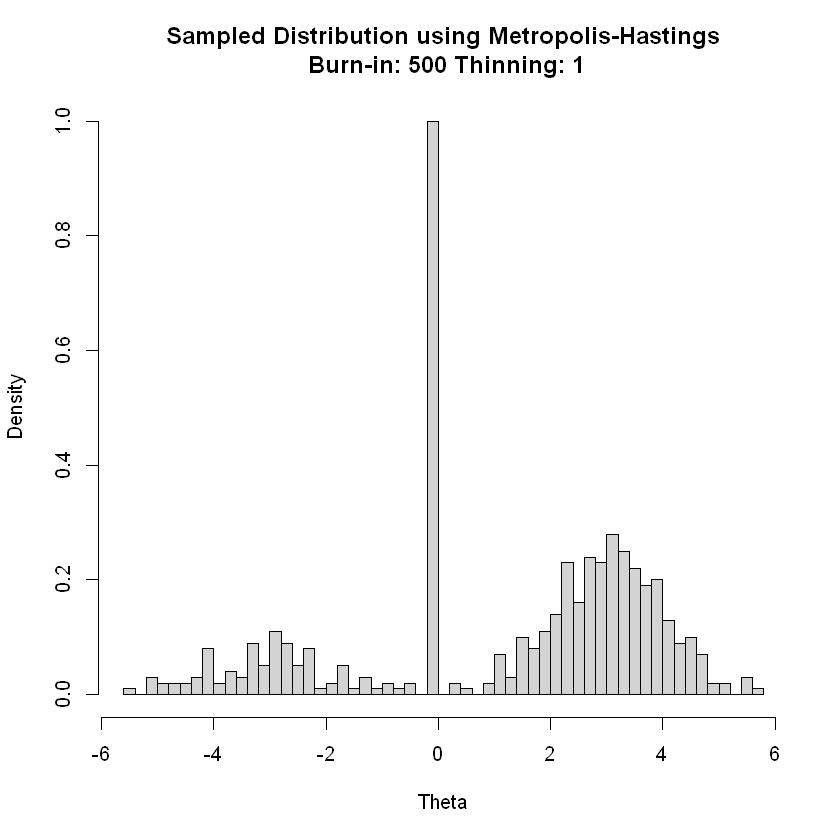

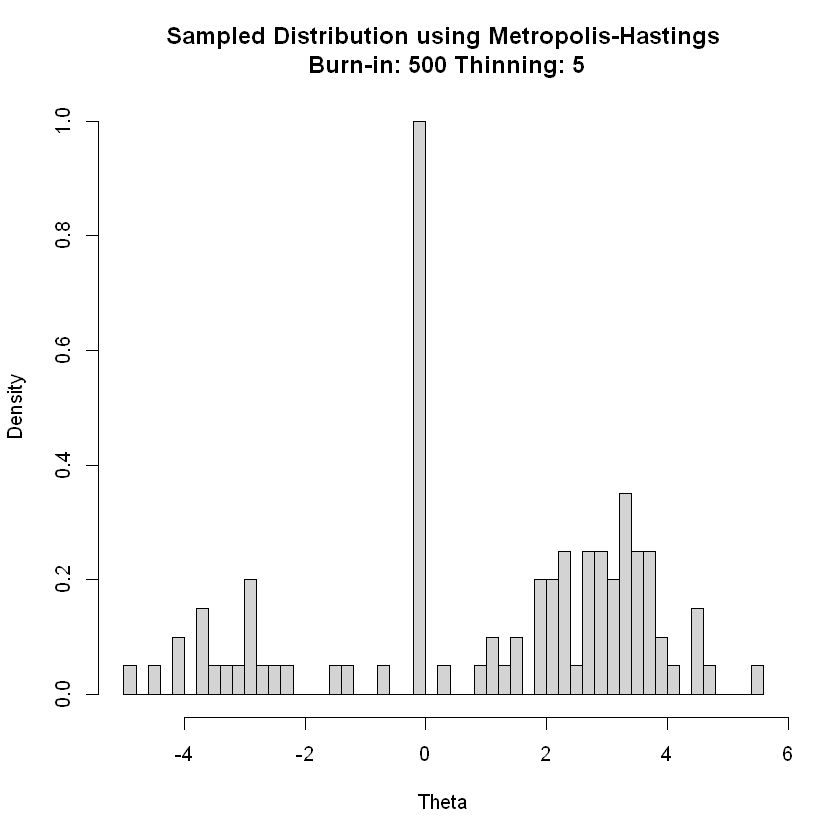

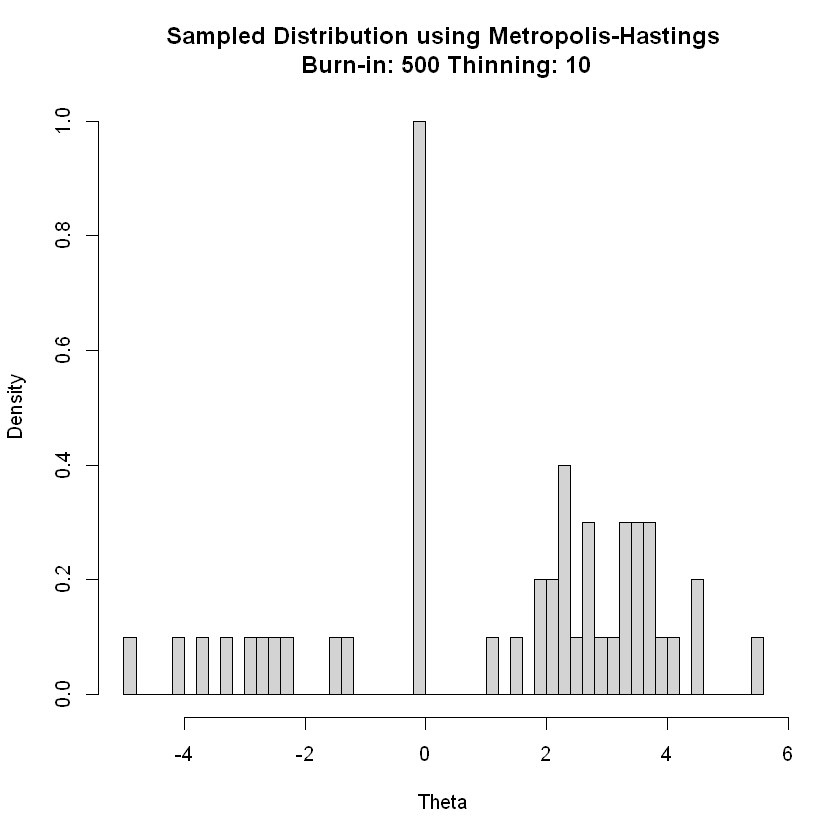

Warning message in min(x):
"nessun argomento non-mancante al minimo; si restituisce Inf"
Warning message in max(x):
"nessun argomento non-mancante al massimo; si restituisce -Inf"


ERROR: Error in hist.default(chain_burn_in_thin, breaks = 50, freq = FALSE, main = paste("Sampled Distribution using Metropolis-Hastings\n", : character(0)


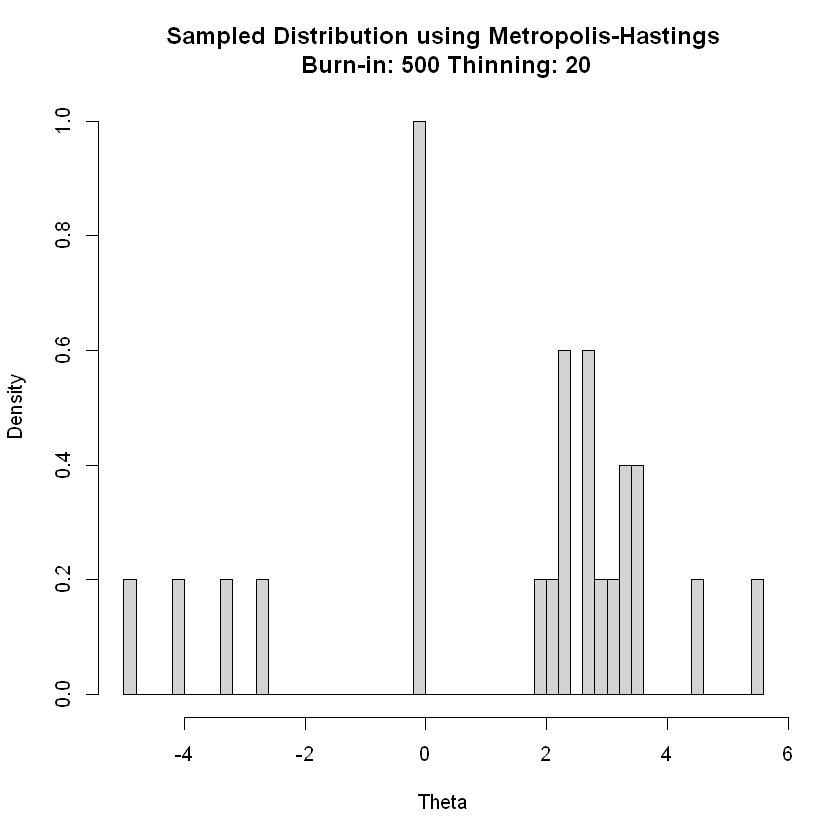

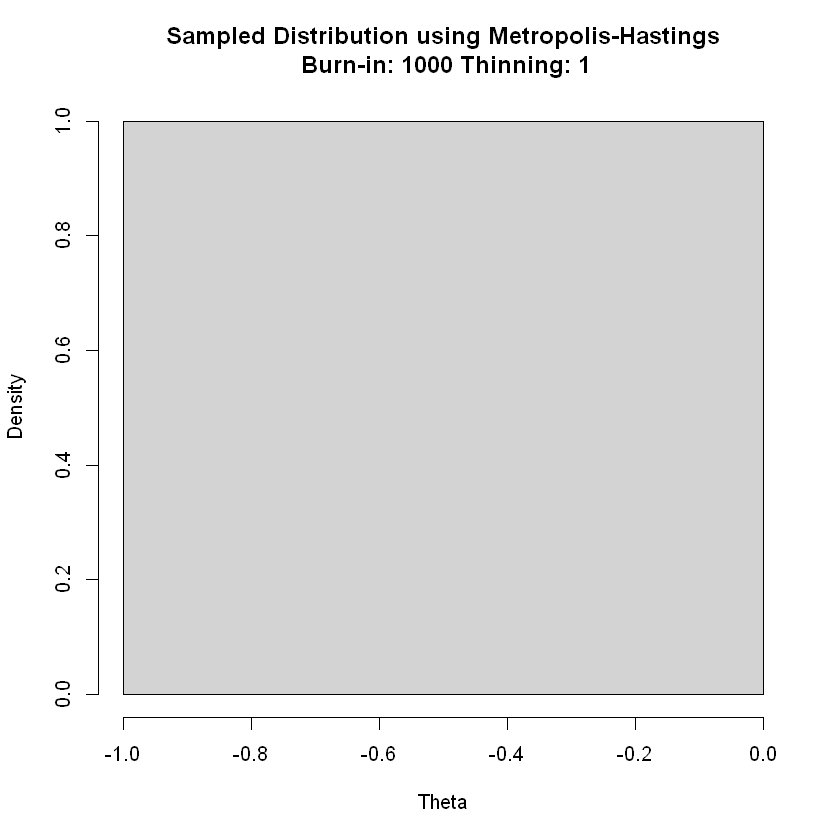

In [30]:
# Try different values of burn-in and thinning
burn_in_values <- c(0, 500, 1000, 2000)
thinning_values <- c(1, 5, 10, 20)

for (burn_in in burn_in_values) {
  for (thinning in thinning_values) {
    # Apply burn-in and thinning
    chain_burn_in_thin <- chain[(burn_in + 1):length(chain)]
    chain_burn_in_thin <- chain_burn_in_thin[seq(1, length(chain_burn_in_thin), by = thinning)]
    
    # Plot the sampled distribution
    hist(chain_burn_in_thin, breaks = 50, freq = FALSE,
         main = paste("Sampled Distribution using Metropolis-Hastings\n",
                      "Burn-in:", burn_in, "Thinning:", thinning),
         xlab = "Theta", ylab = "Density")
    
    # Plot the chain autocorrelation
    chain.df <- as.data.frame(as.mcmc(chain_burn_in_thin))
    ggplot(data = chain.df, aes(x = 1:length(chain_burn_in_thin), y = chain_burn_in_thin)) +
      geom_point(color = 'navy', alpha = 0.5) +
      xlim(0, length(chain_burn_in_thin)) +
      labs(x = 'Iteration', y = 'Theta',
          title = 'Chain Autocorrelation') +
      theme_minimal()
  }
}

In [1]:
# Set the number of iterations, initial value, burn-in, and thinning
num_iterations <- 10000
initial_theta <- 0
burn_in <- 1000
thinning <- 10

# Generate Markov Chain using Metropolis-Hastings algorithm
chain <- metropolis_hastings(num_iterations, initial_theta, thinning, burn_in)

# Apply burn-in and thinning
chain_burn_in_thin <- chain[(burn_in + 1):length(chain)]
chain_burn_in_thin <- chain_burn_in_thin[seq(1, length(chain_burn_in_thin), by = thinning)]

# Plot the sampled distribution
hist(chain_burn_in_thin, breaks = 50, freq = FALSE,
     main = "Sampled Distribution using Metropolis-Hastings",
     xlab = "Theta", ylab = "Density")

# Plot the chain autocorrelation
chain.df <- as.data.frame(as.mcmc(chain_burn_in_thin))
ggplot(data = chain.df, aes(x = 1:length(chain_burn_in_thin), y = chain_burn_in_thin)) +
  geom_point(color = 'navy', alpha = 0.5) +
  xlim(0, length(chain_burn_in_thin)) +
  labs(x = 'Iteration', y = 'Theta',
       title = 'Chain Autocorrelation') +
  theme_minimal()

ERROR: Error in metropolis_hastings(num_iterations, initial_theta, thinning, : non trovo la funzione "metropolis_hastings"


# Exercise 2

## Janssen

In [11]:
tot_vaccine <- 19360
tot_placebo <- 19691
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
janssen.tb <- tibble(tested = tested , patient=patient)
table(janssen.tb[[2]], janssen.tb[[1]])

         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19244   116

In [12]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(janssen.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(janssen.tb$patient )),
Ntot = nrow(janssen.tb) ,
Nclass = nlevels(factor(janssen.tb$patient ))
)

# Run the model
janssen_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(janssen_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Wed May 31 10:22:58 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39051
   Unobserved stochastic nodes: 2
   Total graph size: 78110
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01592160,0.017706650,0.01961720,0.017726933,0.0009368623,NA,4.716326e-06,0.5,39459,0.003063731,1.0000391
theta[2],0.00507015,0.006093065,0.00725055,0.006111288,0.0005603745,NA,2.771807e-06,0.5,40872,0.002940008,0.9999585


In [14]:
janssen_chains.df <- as.data.frame(as.mcmc(janssen_chains))

# Add the differential rate (efficacy of the vaccine)
janssen_res <- janssen_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_janssen <- as.mcmc(janssen_res[,'diff_rate'])
summary(allmcmc2_janssen)

Warning message in as.mcmc.runjags(janssen_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      65.42903        3.66347        0.01832        0.01832 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
57.84 63.05 65.59 68.00 72.16 


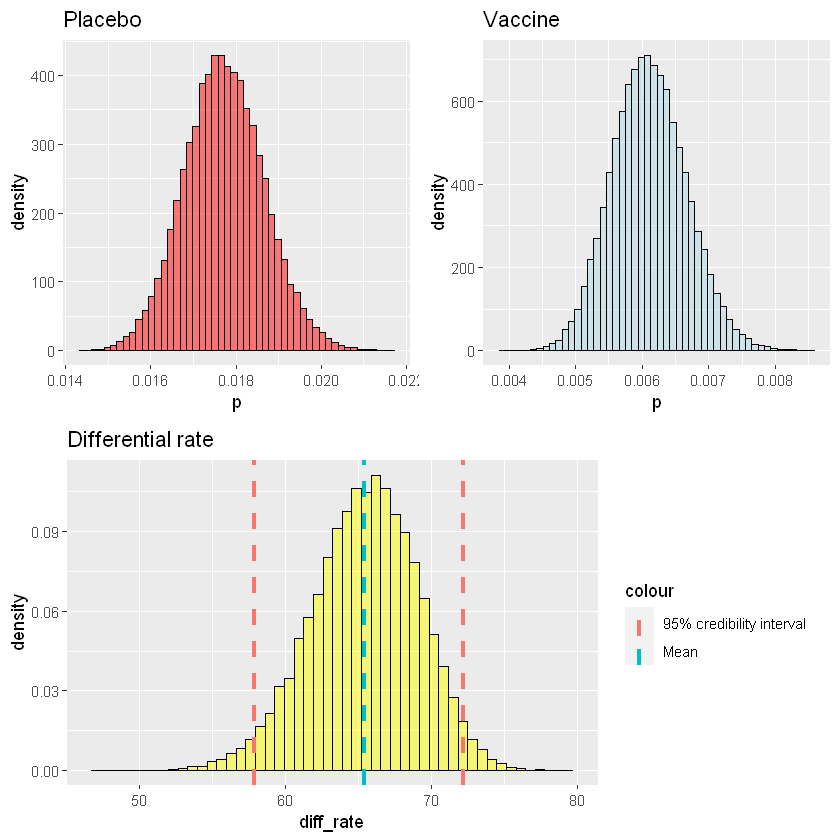

In [39]:
ggplot() +
geom_histogram(aes(x=janssen_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=janssen_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='lightblue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=janssen_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=57.84, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=72.16, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=65.43, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

## Moderna

In [32]:
tot_vaccine <- 14134
tot_placebo <- 14073
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
moderna.tb <- tibble(tested = tested , patient=patient)
table(moderna.tb[[2]], moderna.tb[[1]])

         
            Neg   Pos
  Placebo 13725   348
  Vaccine 14018   116

In [34]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(janssen.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(moderna.tb$patient )),
Ntot = nrow(moderna.tb) ,
Nclass = nlevels(factor(moderna.tb$patient))
)

# Run the model
moderna_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(moderna_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Wed May 31 11:15:23 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 67266
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02209540,0.024722300,0.02724770,0.024748436,0.0013129476,NA,6.562808e-06,0.5,40024,0.005758822,0.9999960
theta[2],0.00691774,0.008339005,0.00991017,0.008360245,0.0007642909,NA,3.802159e-06,0.5,40407,0.008415835,0.9999746


In [36]:
moderna_chains.df <- as.data.frame(as.mcmc(moderna_chains))

# Add the differential rate (efficacy of the vaccine)
moderna_res <- moderna_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_moderna <- as.mcmc(janssen_res[,'diff_rate'])
summary(allmcmc2_moderna)

Warning message in as.mcmc.runjags(moderna_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      65.42903        3.66347        0.01832        0.01832 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
57.84 63.05 65.59 68.00 72.16 


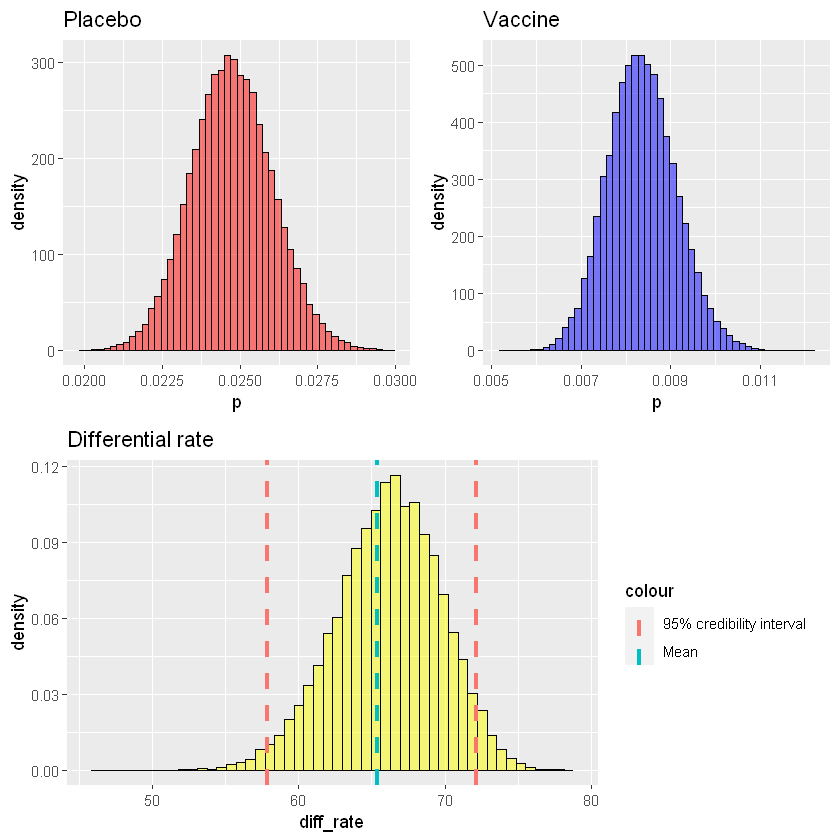

In [40]:
ggplot() +
geom_histogram(aes(x=moderna_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=moderna_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='blue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=moderna_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=57.84, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=72.16, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=65.42, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

## Astrazeneca

In [42]:
tot_vaccine <- 5258
tot_placebo <- 5210
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 64
pos_placebo <- 154
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
astra.tb <- tibble(tested = tested , patient=patient)
table(astra.tb[[2]],astra.tb[[1]])

         
           Neg  Pos
  Placebo 5056  154
  Vaccine 5194   64

In [44]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(astra.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(astra.tb$patient )),
Ntot = nrow(astra.tb) ,
Nclass = nlevels(factor(astra.tb$patient))
)

# Run the model
astra_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(astra_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Wed May 31 11:33:02 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20944
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02515040,0.02949150,0.0342706,0.02956180,0.002329160,NA,1.181688e-05,0.5,38850,-0.001490268,0.9999628
theta[2],0.00955126,0.01244255,0.0154593,0.01249872,0.001516909,NA,7.617089e-06,0.5,39659,-0.006132956,0.9999975


In [46]:
astra_chains.df <- as.data.frame(as.mcmc(astra_chains))

# Add the differential rate (efficacy of the vaccine)
astra_res <- astra_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_astra <- as.mcmc(astra_res[,'diff_rate'])
summary(allmcmc2_astra)

Warning message in as.mcmc.runjags(astra_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      57.45469        6.19695        0.03098        0.03098 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
44.22 53.59 57.88 61.78 68.42 


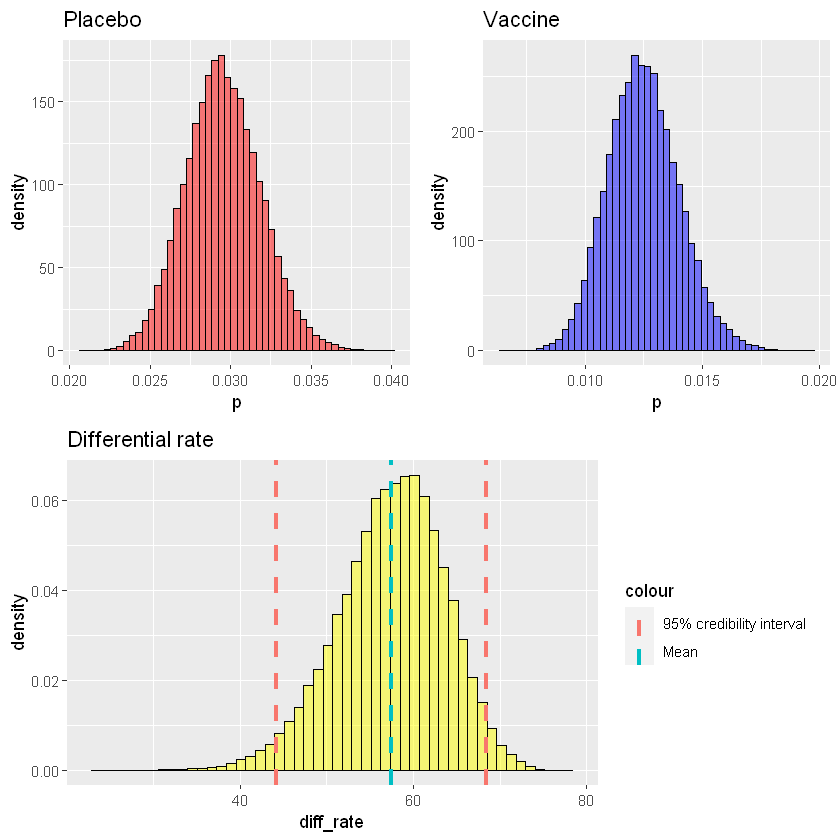

In [48]:
ggplot() +
geom_histogram(aes(x=astra_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=astra_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='blue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=astra_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=44.22, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=68.42, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=57.45, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

# Exercise 3

Rows: 170463 Columns: 16
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (2): location, iso_code
dbl  (13): total_vaccinations, people_vaccinated, people_fully_vaccinated, t...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


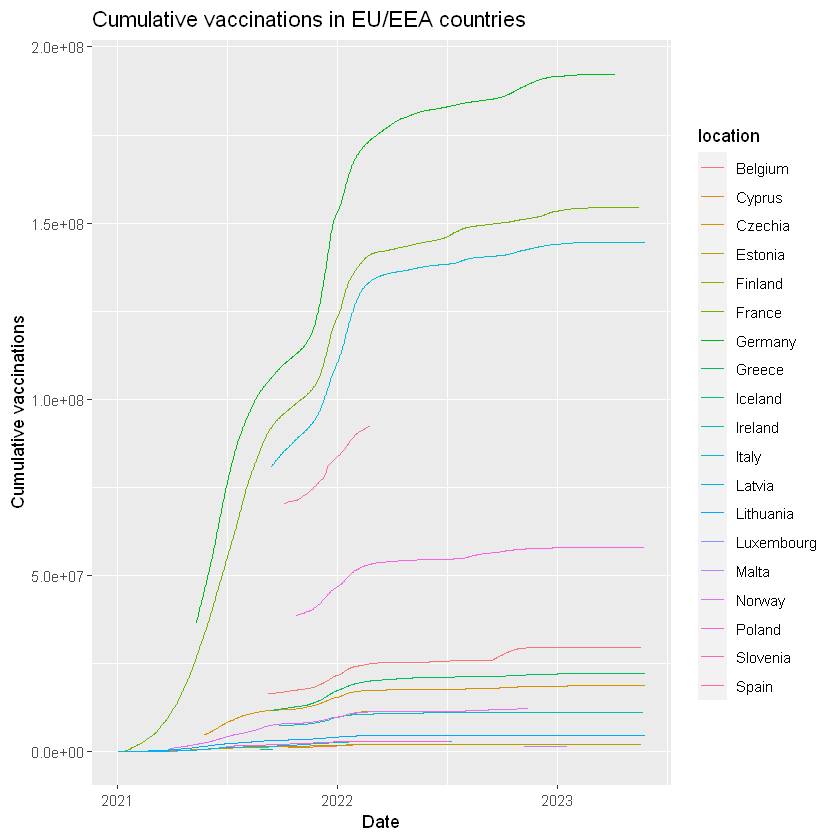

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


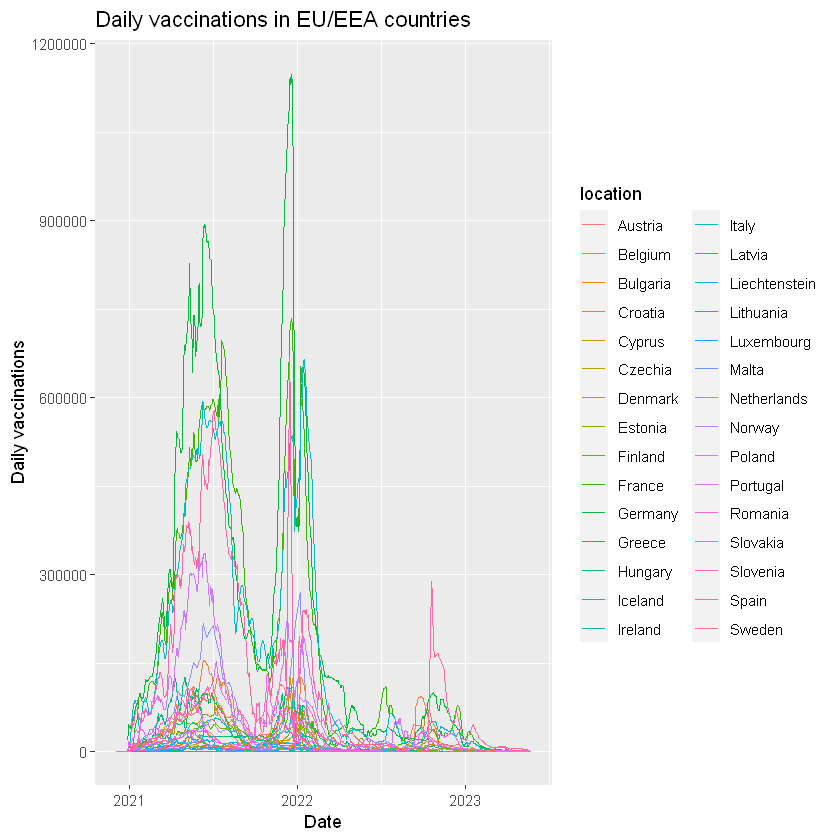

Rows: 313167 Columns: 67
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (4): iso_code, continent, location, tests_units
dbl  (62): total_cases, new_cases, new_cases_smoothed, total_deaths, new_dea...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Removed 677 rows containing missing values (`geom_line()`)."


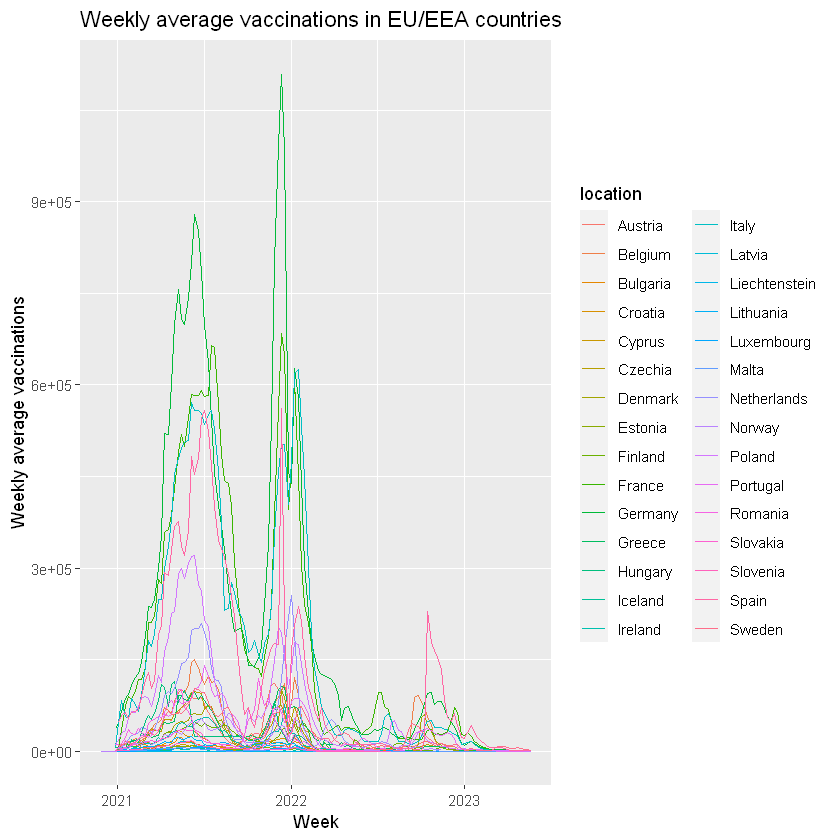

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.
Warning message:
"Removed 19 rows containing missing values (`geom_line()`)."


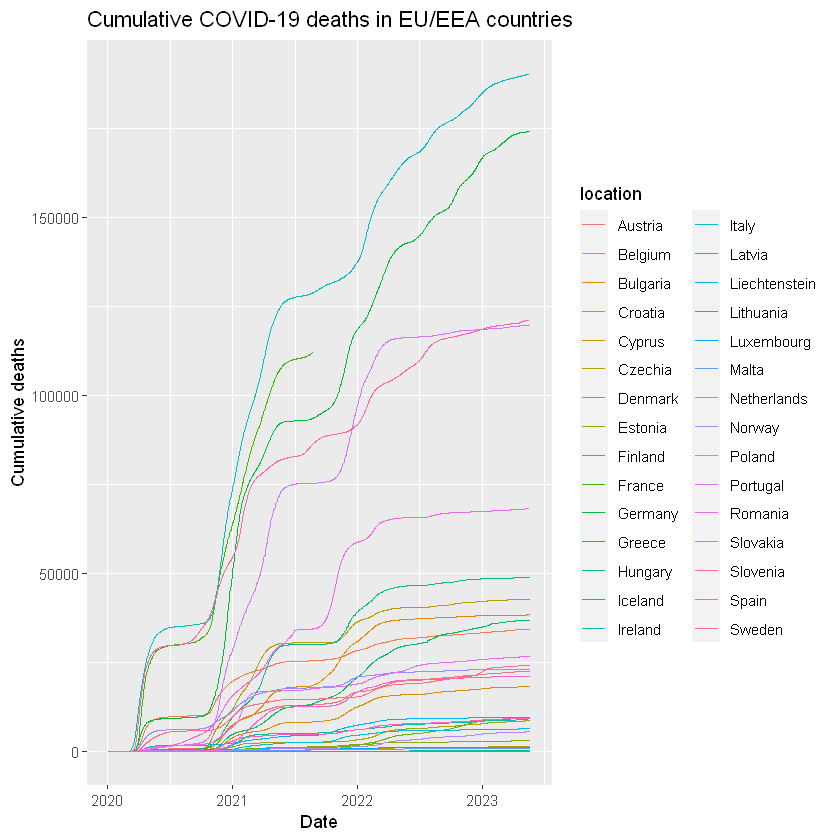

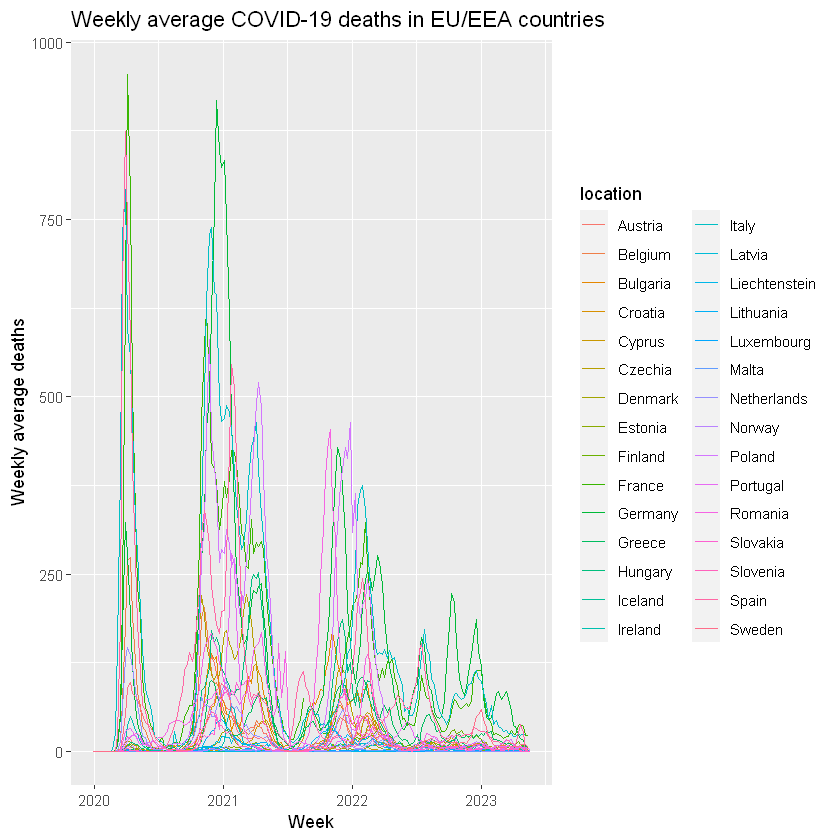

In [9]:
# Read in data
data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# Filter for EU/EEA countries
eu_eea_countries <- c("Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden")
data_eu_eea <- data %>% filter(location %in% eu_eea_countries & !is.na(daily_vaccinations))

# Calculate cumulative vaccinations
cumulative_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_vaccinations = cumsum(daily_vaccinations)) %>%
  ungroup()

# Plot cumulative vaccinations
cumulative_vaccinations %>%
  na.omit() %>%
  ggplot(aes(x = date, y = cumulative_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Cumulative vaccinations in EU/EEA countries",
       x = "Date",
       y = "Cumulative vaccinations")

# Calculate daily vaccinations
daily_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(daily_vaccinations = daily_vaccinations) %>%
  ungroup()

# Plot daily vaccinations
daily_vaccinations %>%
  ggplot(aes(x = date, y = daily_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Daily vaccinations in EU/EEA countries",
       x = "Date",
       y = "Daily vaccinations")

# Calculate weekly average vaccinations
weekly_avg_vaccinations <- data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_vaccinations = mean(daily_vaccinations)) %>%
  ungroup()

# Plot weekly average vaccinations
weekly_avg_vaccinations %>%
  ggplot(aes(x = week, y = weekly_avg_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Weekly average vaccinations in EU/EEA countries",
       x = "Week",
       y = "Weekly average vaccinations")

# Read in deaths data
deaths_data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

# Filter for EU/EEA countries
deaths_data_eu_eea <- deaths_data %>% filter(location %in% eu_eea_countries)

# Calculate cumulative deaths
cumulative_deaths <- deaths_data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_deaths = cumsum(new_deaths)) %>%
  ungroup()

# Plot cumulative deaths
cumulative_deaths %>%
  ggplot(aes(x = date, y = cumulative_deaths, color = location)) +
  geom_line() +
  labs(title = "Cumulative COVID-19 deaths in EU/EEA countries",
       x = "Date",
       y = "Cumulative deaths")

# Calculate weekly average deaths
weekly_avg_deaths <- deaths_data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_deaths = mean(new_deaths)) %>%
  ungroup()

# Plot weekly average deaths
weekly_avg_deaths %>%
  ggplot(aes(x = week, y = weekly_avg_deaths, color = location)) +
  geom_line() +
  labs(title = "Weekly average COVID-19 deaths in EU/EEA countries",
       x = "Week",
       y = "Weekly average deaths")

In [ ]:
# Check for missing values
sum(is.na(cumulative_vaccinations$cumulative_vaccinations))

[1] 23875